#Mejora y Segmentación de Imágenes Satelitales con Aprendizaje Profundo
##Introducción
Este cuaderno demuestra el proceso de mejora y segmentación de imágenes satelitales utilizando técnicas de aprendizaje profundo. La segmentación de imágenes es una tarea esencial en diversas aplicaciones de teledetección, como el monitoreo ambiental, la gestión de recursos naturales y el análisis urbano.

En este tutorial, utilizaremos bibliotecas de Python como TensorFlow, Keras y scikit-image para procesar imágenes satelitales y desarrollar un modelo de segmentación basado en la arquitectura U-Net. Los pasos clave incluyen:

- Preparación de Conjuntos de Datos: Cargar y preprocesar una imagen satelital, creando parches para aumentar el número de muestras.
- Aumento de Datos: Aplicar técnicas de aumento de datos para mejorar la generalización del modelo.
- Entrenamiento del Modelo: Construir y entrenar una red neuronal convolucional (CNN) utilizando la arquitectura U-Net para realizar la segmentación semántica de las imágenes.
- Evaluación del Modelo: Evaluar el rendimiento del modelo en datos de prueba y ajustar los hiperparámetros según sea necesario.

##Paso 1: Preparación de Conjuntos de Datos
En la primera celda de tu cuaderno, instala las bibliotecas necesarias ejecutando el siguiente código:

In [1]:
!pip install numpy pandas matplotlib
!pip install scikit-image
!pip install tensorflow keras

###Importa las bibliotecas que usarás:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###Descarga una imagen de ejemplo en formato PNG:

In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png -O satellite_image.png

--2024-05-31 21:37:09--  https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226933 (222K) [image/png]
Saving to: ‘satellite_image.png’

satellite_image.png 100%[===================>] 221.61K  --.-KB/s    in 0.05s   

2024-05-31 21:37:09 (4.13 MB/s) - ‘satellite_image.png’ saved [226933/226933]



###Carga y muestra la imagen:

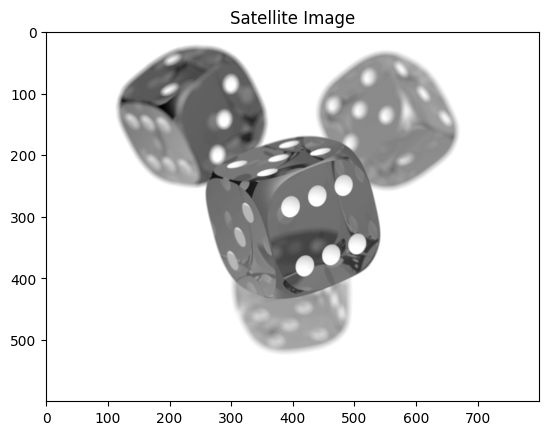

In [4]:
image_path = 'satellite_image.png'
image = io.imread(image_path, as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("Satellite Image")
plt.show()

###Normaliza la imagen:

In [5]:
image = image.astype('float32') / 255.0

##Paso 3: Aumento de Datos
Crea etiquetas simuladas:

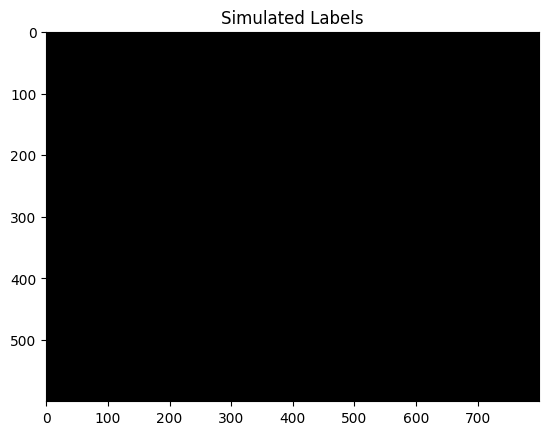

In [6]:
labels = (image > 0.5).astype(int)
plt.imshow(labels, cmap='gray')
plt.title('Simulated Labels')
plt.show()

###Crea parches de la imagen:

In [7]:
from sklearn.feature_extraction.image import extract_patches_2d

patch_size = (64, 64)
image_patches = extract_patches_2d(image, patch_size, max_patches=500, random_state=42)
label_patches = extract_patches_2d(labels, patch_size, max_patches=500, random_state=42)

image_patches = image_patches.reshape(-1, patch_size[0], patch_size[1], 1)
label_patches = label_patches.reshape(-1, patch_size[0], patch_size[1], 1)


###Divide los datos en entrenamiento y prueba:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_patches, label_patches, test_size=0.2, random_state=42)

###Crea un generador de datos para el aumento:

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def generator(features, labels, batch_size):
    data_gen = datagen.flow(features, labels, batch_size=batch_size, seed=42)
    while True:
        X, y = data_gen.next()
        yield X, y

batch_size = 32
train_generator = generator(X_train, y_train, batch_size)
validation_generator = generator(X_test, y_test, batch_size)

##Paso 4: Crear y Entrenar el Modelo
Crea el modelo U-Net:

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_size=(64, 64, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

###Entrena el modelo

In [11]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_steps)

Epoch 1/10
12/12 [==============================] - 305s 24s/step - loss: 0.1793 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 263s 23s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 258s 21s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 252s 21s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 261s 22s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 248s 21s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 253s 21s/step - loss: 0.0000e+00 - accuracy: 1.0000 

##Paso 5: Evaluar el Modelo
Evalúa el modelo en los datos de prueba:

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')
print(f'Model Accuracy: {accuracy}')

4/4 [==============================] - 15s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000
Model Loss: 0.0
Model Accuracy: 1.0
